# tSNE Visualization of PACS features after training

## Imports

In [41]:
import numpy as np
import torch
from torchvision import transforms as T
from torch.utils.data import ConcatDataset, DataLoader

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

from pathlib import Path

from tqdm.notebook import tqdm

import sys
sys.path.append("..")

from data import pacs

from models import resnet_ms, custom_models

## Specify model (checkpoint must exist)

In [25]:
MODEL = resnet_ms.resnet50_fc512
EVAL_DOMAIN = "sketch" # Domain model was evaluated on
SETUP = "pacs" # "pacs" or "pacs_threefold"
PRETRAINED = True

## Check for CUDA support

In [26]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Device: {device}")

Device: cuda


## PACS metadata

In [27]:
NUM_CLASSES = 7
CLASSES = ["dog", "elephant", "giraffe", "guitar", "horse", "house", "person"]
DOMAINS = ["art_painting", "cartoon", "photo", "sketch"]

## Load desired model

In [28]:
model_name = f"best_{EVAL_DOMAIN}_{MODEL.__name__}"
model_dir = f"../checkpoints/{SETUP}"
model_path = Path(f"{model_dir}/{model_name}.pt")

model = MODEL(NUM_CLASSES, pretrained=PRETRAINED)
model.load_state_dict(torch.load(model_path))

model = model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Normalization statistics

In [29]:
# Values for pretrained ResNet
pretrained_image_transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Parameters

In [30]:
# Parameters for Vis
perplexity = 30
pca_dims = 50
tsne_iters = 2000
seed = 42

## Make tSNE plots

In [38]:
val_sets = []
for d in DOMAINS:
    _, vl = pacs.get_data_loaders(
        d,
        train_batch_size=16,
        transform=pretrained_image_transform,
        shuffle_test=False,
        drop_last=False
    )
    val_sets.append(vl.dataset)

combined_val = ConcatDataset(val_sets)
combined_loader = DataLoader(
    combined_val,
    batch_size=16,
    shuffle=False,
    num_workers=10
)
print(f"Combined loader size: {len(combined_val)} samples")

Combined loader size: 9991 samples


In [39]:
def extract_features_with_pooling(model, layer_name, data_loader, max_samples=2000):
    """Extract features with global average pooling to reduce memory usage"""
    model.eval()
    all_features = []
    all_class_labels = []
    all_domain_labels = []

    sample_count = 0

    with torch.no_grad():
        for batch_idx, (data, class_labels, domain_labels) in enumerate(tqdm(data_loader)):
            if sample_count >= max_samples:
                break

            data = data.cuda()

            # Extract features from specified layer
            if layer_name == "layer1":
                x = model.conv1(data)
                x = model.bn1(x)
                x = model.relu(x)
                x = model.maxpool(x)
                features = model.layer1(x)
            elif layer_name == "layer2":
                x = model.conv1(data)
                x = model.bn1(x)
                x = model.relu(x)
                x = model.maxpool(x)
                x = model.layer1(x)
                features = model.layer2(x)
            elif layer_name == "layer3":
                x = model.conv1(data)
                x = model.bn1(x)
                x = model.relu(x)
                x = model.maxpool(x)
                x = model.layer1(x)
                x = model.layer2(x)
                features = model.layer3(x)
            elif layer_name == "layer4":
                x = model.conv1(data)
                x = model.bn1(x)
                x = model.relu(x)
                x = model.maxpool(x)
                x = model.layer1(x)
                x = model.layer2(x)
                x = model.layer3(x)
                features = model.layer4(x)
            else:
                # For final features (after avgpool)
                features = model(data)

            # Apply global average pooling if features are 4D (spatial)
            if len(features.shape) == 4:  # [batch, channels, height, width]
                features = F.adaptive_avg_pool2d(
                    features, (1, 1))  # -> [batch, channels, 1, 1]
                # -> [batch, channels]
                features = features.view(features.size(0), -1)

            all_features.append(features.cpu())
            all_class_labels.append(class_labels)
            all_domain_labels.append(domain_labels)

            sample_count += data.size(0)

    return torch.cat(all_features), torch.cat(all_class_labels), torch.cat(all_domain_labels)

def generate_tSNE_memory_efficient(model, layer_name, save_name, max_samples=2000):
    """Generate t-SNE with memory-efficient processing"""

    # Extract features with pooling
    features, class_labels, domain_labels = extract_features_with_pooling(
        model, layer_name, combined_loader, max_samples
    )

    # Truncate to max_samples if needed
    if features.shape[0] > max_samples:
        features = features[:max_samples]
        class_labels = class_labels[:max_samples]
        domain_labels = domain_labels[:max_samples]

    print(f"Feature shape after pooling: {features.shape}")
    print(
        f"Memory usage: {features.element_size() * features.nelement() / 1024**3:.2f} GB")

    # Convert to numpy with memory-efficient dtype
    features_np = features.numpy().astype(np.float32)
    class_labels_np = class_labels.numpy()
    domain_labels_np = domain_labels.numpy()

    # Clear GPU memory
    del features, class_labels, domain_labels
    torch.cuda.empty_cache()

    # Apply PCA first to reduce dimensions further
    print(
        f"Applying PCA to reduce from {features_np.shape[1]} to {pca_dims} dimensions...")
    pca = PCA(n_components=min(pca_dims, features_np.shape[1]))
    features_pca = pca.fit_transform(features_np)

    print(
        f"PCA explained variance ratio: {pca.explained_variance_ratio_.sum():.3f}")

    # Apply t-SNE
    print("Applying t-SNE...")
    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        n_iter=tsne_iters,
        random_state=seed,
        verbose=1
    )

    features_tsne = tsne.fit_transform(features_pca)

    # Create visualization
    plt.figure(figsize=(15, 5))

    # Plot by class
    plt.subplot(1, 3, 1)
    scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1],
                          c=class_labels_np, cmap='tab10', alpha=0.7, s=20)
    plt.colorbar(scatter)
    plt.title(f'{save_name} - Colored by Class')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')

    # Plot by domain
    plt.subplot(1, 3, 2)
    scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1],
                          c=domain_labels_np, cmap='Set1', alpha=0.7, s=20)
    plt.colorbar(scatter)
    plt.title(f'{save_name} - Colored by Domain')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')

    # Combined plot with class and domain
    plt.subplot(1, 3, 3)
    unique_domains = np.unique(domain_labels_np)
    colors = plt.cm.Set1(np.linspace(0, 1, len(unique_domains)))

    for i, domain in enumerate(unique_domains):
        mask = domain_labels_np == domain
        plt.scatter(features_tsne[mask, 0], features_tsne[mask, 1],
                    c=[colors[i]], label=f'Domain {domain}', alpha=0.7, s=20)

    plt.legend()
    plt.title(f'{save_name} - Domains')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')

    plt.tight_layout()
    plt.savefig(f'tsne_{save_name}.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Calculate silhouette scores
    sil_class = silhouette_score(features_tsne, class_labels_np)
    sil_domain = silhouette_score(features_tsne, domain_labels_np)

    print(f"Silhouette Score (Class): {sil_class:.3f}")
    print(f"Silhouette Score (Domain): {sil_domain:.3f}")

    return features_tsne, class_labels_np, domain_labels_np

## Layer 1

In [42]:
# @torch.no_grad()
# def layer1(x):
#     x = model.conv1(x)
#     x = model.bn1(x)
#     x = model.relu(x)
#     x = model.maxpool(x)
#     x = model.layer1(x)
#     if 'layer1' in model.mixstyle_layers:
#         x = model.mixstyle(x)
#     return x

generate_tSNE_memory_efficient(model, "layer1", f"{MODEL.__name__}_l1")

  0%|          | 0/625 [00:00<?, ?it/s]

MemoryError: 

## Layer 2

DIAGNOSTIC INFO:
Raw model output shape: torch.Size([16, 512, 28, 28])
Flattening torch.Size([16, 512, 28, 28]) -> torch.Size([16, 401408])
Flattened feature shape: torch.Size([16, 401408])
Feature dimension: 401408
Memory per sample: 1605632 bytes (1.61 MB)
Estimated memory for 500 samples: 0.80 GB
Flattening torch.Size([16, 512, 28, 28]) -> torch.Size([16, 401408])
Flattening torch.Size([16, 512, 28, 28]) -> torch.Size([16, 401408])
Flattening torch.Size([16, 512, 28, 28]) -> torch.Size([16, 401408])
Flattening torch.Size([16, 512, 28, 28]) -> torch.Size([16, 401408])
Flattening torch.Size([16, 512, 28, 28]) -> torch.Size([16, 401408])
Flattening torch.Size([16, 512, 28, 28]) -> torch.Size([16, 401408])
Flattening torch.Size([16, 512, 28, 28]) -> torch.Size([16, 401408])
Flattening torch.Size([16, 512, 28, 28]) -> torch.Size([16, 401408])
Flattening torch.Size([16, 512, 28, 28]) -> torch.Size([16, 401408])
Flattening torch.Size([16, 512, 28, 28]) -> torch.Size([16, 401408])
Flattenin

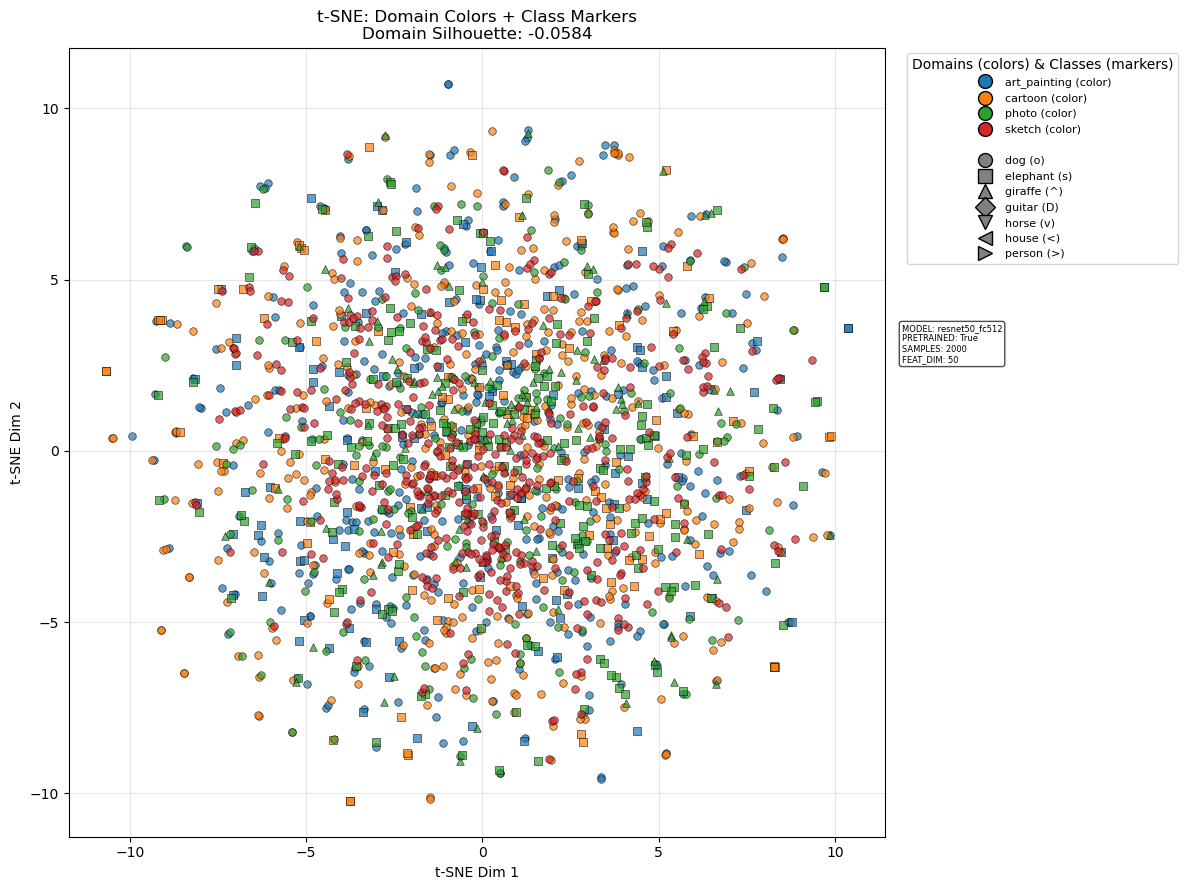

In [ ]:
@torch.no_grad()
def layer2(x):
    x = layer1(x)
    x = model.layer2(x)
    if 'layer2' in model.mixstyle_layers:
        x = model.mixstyle(x)
    return x

generate_tSNE(layer2, f"{MODEL.__name__}_l2")

## Layer 3

DIAGNOSTIC INFO:
Raw model output shape: torch.Size([16, 1024, 14, 14])
Flattening torch.Size([16, 1024, 14, 14]) -> torch.Size([16, 200704])
Flattened feature shape: torch.Size([16, 200704])
Feature dimension: 200704
Memory per sample: 802816 bytes (0.80 MB)
Estimated memory for 500 samples: 0.40 GB
Flattening torch.Size([16, 1024, 14, 14]) -> torch.Size([16, 200704])
Flattening torch.Size([16, 1024, 14, 14]) -> torch.Size([16, 200704])
Flattening torch.Size([16, 1024, 14, 14]) -> torch.Size([16, 200704])
Flattening torch.Size([16, 1024, 14, 14]) -> torch.Size([16, 200704])
Flattening torch.Size([16, 1024, 14, 14]) -> torch.Size([16, 200704])
Flattening torch.Size([16, 1024, 14, 14]) -> torch.Size([16, 200704])
Flattening torch.Size([16, 1024, 14, 14]) -> torch.Size([16, 200704])
Flattening torch.Size([16, 1024, 14, 14]) -> torch.Size([16, 200704])
Flattening torch.Size([16, 1024, 14, 14]) -> torch.Size([16, 200704])
Flattening torch.Size([16, 1024, 14, 14]) -> torch.Size([16, 200704]

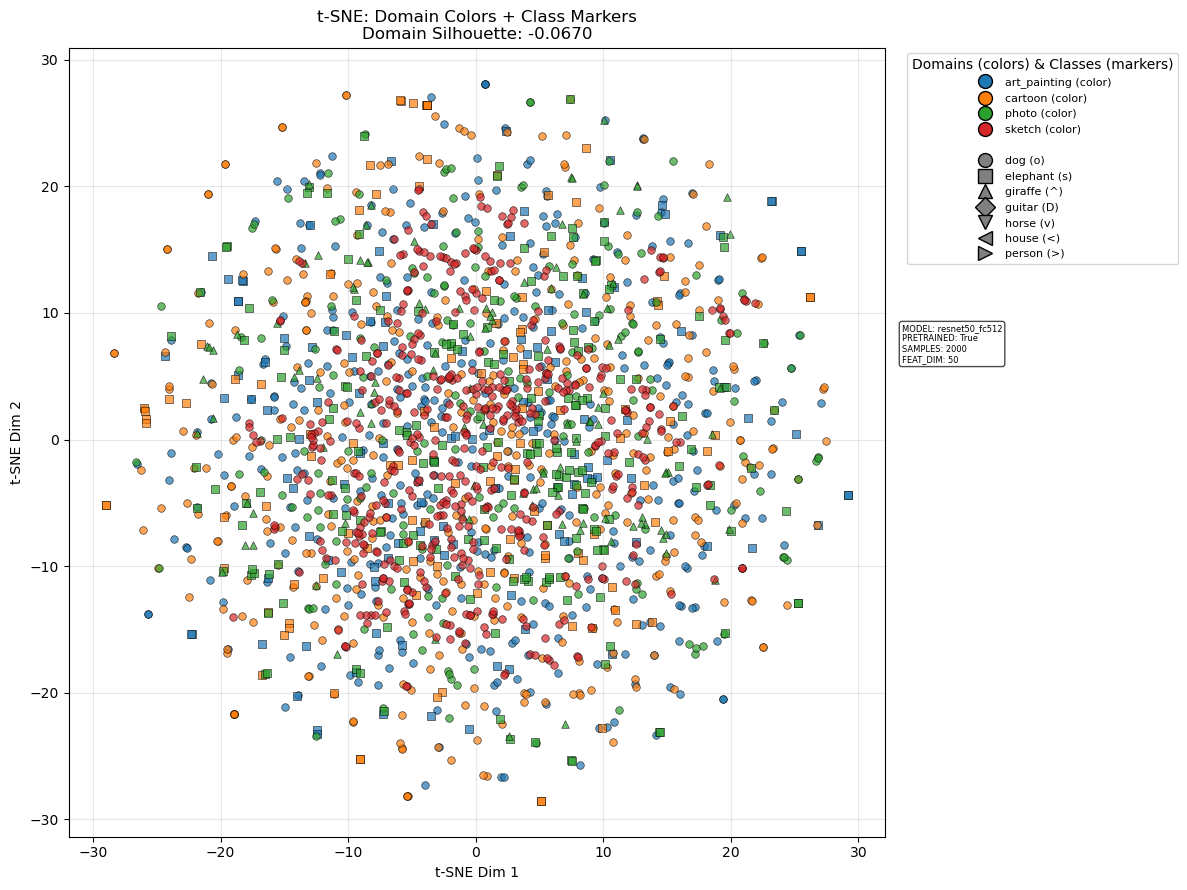

In [ ]:
@torch.no_grad()
def layer3(x):
    x = layer2(x)
    x = model.layer3(x)
    if 'layer3' in model.mixstyle_layers:
        x = model.mixstyle(x)
    return x


generate_tSNE(layer3, f"{MODEL.__name__}_l3")

## Layer 4

DIAGNOSTIC INFO:
Raw model output shape: torch.Size([16, 2048, 14, 14])
Flattening torch.Size([16, 2048, 14, 14]) -> torch.Size([16, 401408])
Flattened feature shape: torch.Size([16, 401408])
Feature dimension: 401408
Memory per sample: 1605632 bytes (1.61 MB)
Estimated memory for 500 samples: 0.80 GB
Flattening torch.Size([16, 2048, 14, 14]) -> torch.Size([16, 401408])
Flattening torch.Size([16, 2048, 14, 14]) -> torch.Size([16, 401408])
Flattening torch.Size([16, 2048, 14, 14]) -> torch.Size([16, 401408])
Flattening torch.Size([16, 2048, 14, 14]) -> torch.Size([16, 401408])
Flattening torch.Size([16, 2048, 14, 14]) -> torch.Size([16, 401408])
Flattening torch.Size([16, 2048, 14, 14]) -> torch.Size([16, 401408])
Flattening torch.Size([16, 2048, 14, 14]) -> torch.Size([16, 401408])
Flattening torch.Size([16, 2048, 14, 14]) -> torch.Size([16, 401408])
Flattening torch.Size([16, 2048, 14, 14]) -> torch.Size([16, 401408])
Flattening torch.Size([16, 2048, 14, 14]) -> torch.Size([16, 401408

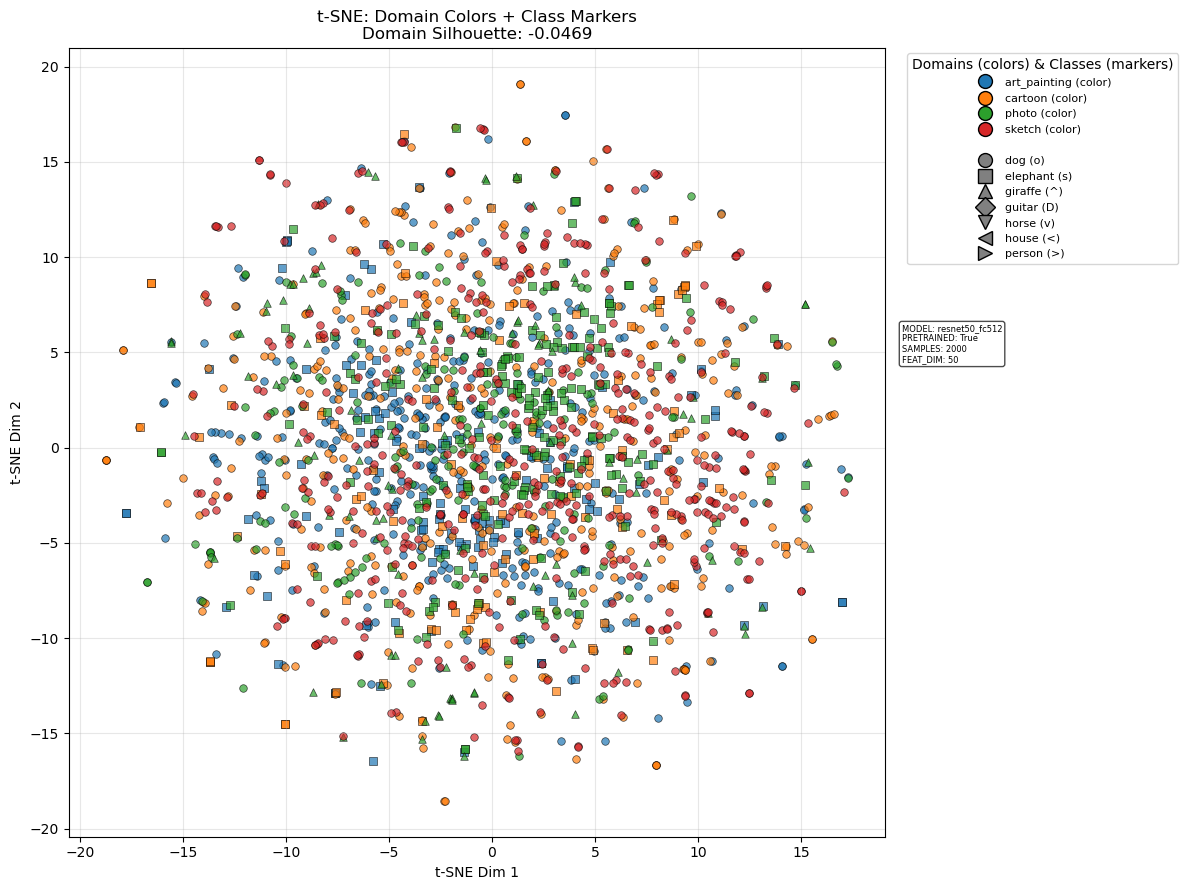

In [ ]:
@torch.no_grad()
def layer4(x):
    x = layer3(x)
    x = model.layer4(x)
    if 'layer4' in model.mixstyle_layers:
        x = model.mixstyle(x)
    return x


generate_tSNE(layer4, f"{MODEL.__name__}_l4")

## Right before classifier

DIAGNOSTIC INFO:
Raw model output shape: torch.Size([16, 512])
Flattened feature shape: torch.Size([16, 512])
Feature dimension: 512
Memory per sample: 2048 bytes (0.00 MB)
Estimated memory for 500 samples: 0.00 GB
Domain art_painting: extracted 500 samples with feature dim 512
Domain cartoon: extracted 500 samples with feature dim 512
Domain photo: extracted 500 samples with feature dim 512
Domain sketch: extracted 500 samples with feature dim 512
Extracted 2000 features across 4 domains and 7 classes
t-SNE embedding complete
Silhouette Score (Domain): 0.1862
Plot saved as: tsne_pacs_resnet50_fc512_pretrainedTrue_sil_dom0d1862_n2000.png


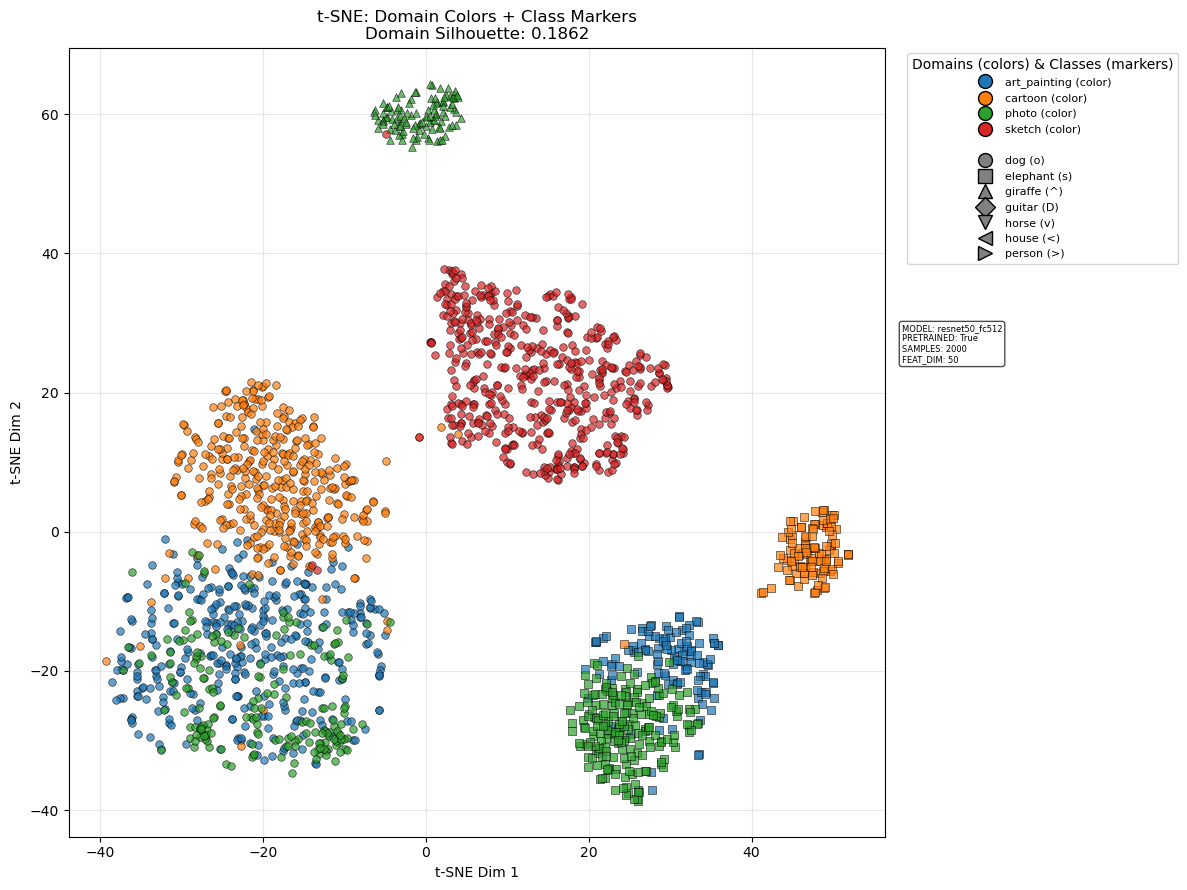

In [ ]:
generate_tSNE(model, f"{MODEL.__name__}")